In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform
from glob import glob
import pickle

from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_validate, KFold

from rogi import RoughnessIndex, RMODI

from tdc.generation import MolGen
from tdc import Oracle
from tdc.single_pred import ADME, Tox

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
import seaborn as sns
sns.set(style='ticks')

In [2]:
def compute_rdkit_descriptors(smi):
    m = Chem.MolFromSmiles(smi)
    descriptor_names = [desc[0] for desc in Descriptors.descList]
    descriptor_funcs = [desc[1] for desc in Descriptors.descList]
    descriptors = [desc(m) for desc in descriptor_funcs]
    return descriptors


def smiles_to_descriptors_df(smiles, descriptors=None):
    Xdict = {}
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    for desc in Descriptors.descList:
        name = desc[0]
        f = desc[1]

        if descriptors is not None and name in descriptors:
            Xdict[name] = [f(m) for m in mols]
    return pd.DataFrame(Xdict)
    

def plot_scatter(ax, x, y, title='', marker='X', s=100, 
                 fit=False, fit_outline=True, fit_lw=1, fit_zorder=0,
                 color='b', edgecolor='k', linewidth=0.5, alpha_face=1, alpha_edge=1,
                 annotate=True, text_color='k', x_text=0.55, y_text=0.9, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label=''):

    if fit:
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        if fit_outline:
            ax.plot([min(x), max(x)], [poly1d_fn(min(x)), poly1d_fn(max(x))], linestyle='-', color='white', zorder=fit_zorder-1, linewidth=fit_lw+1)
        ax.plot([min(x), max(x)], [poly1d_fn(min(x)), poly1d_fn(max(x))], linestyle='--', color=color, zorder=fit_zorder, linewidth=fit_lw)

    # face
    ax.scatter(x, y, marker=marker, s=s, color=color, edgecolor='none', linewidth=0, alpha=alpha_face, zorder=zorder_scatter, label=label)
    # edges
    ax.scatter(x, y, marker=marker, s=s, facecolor="none", edgecolor=edgecolor, linewidth=linewidth, alpha=alpha_edge, zorder=zorder_scatter)

    ax.set_title(title)

    if annotate:
        pears = pearsonr(x, y)[0]
        _ = ax.annotate(f'$r = {pears:.2f}$', xy=(x_text, y_text), xycoords='axes fraction', ha='right', color=text_color, fontsize=fontsize,
                        zorder=10, path_effects=[pe.withStroke(linewidth=2, foreground="white")])

In [3]:
# ----------------
# Guacamol Oracles
# ----------------
# NOTE: we do not use "Sitagliptin_MPO" because it returns NaNs for some SMILES
oracle_names = ['QED', 'LogP', 'Celecoxib_Rediscovery', 'Aripiprazole_Similarity', 'Median 1', 
                'Osimertinib_MPO', 'Fexofenadine_MPO', 'Ranolazine_MPO', 'Perindopril_MPO', 'Amlodipine_MPO', 'Zaleplon_MPO',
                'Valsartan_SMARTS', 'Scaffold Hop']

# ------------------------
# TDC regression datasets
# ------------------------
adme_props = [('Caco2_Wang', None), 
              ('Lipophilicity_AstraZeneca', None), 
              ('Solubility_AqSolDB', None), 
              ('HydrationFreeEnergy_FreeSolv', None), 
              ('PPBR_AZ', None), 
              ('VDss_Lombardo', None),
              ('Half_Life_Obach', None), 
              ('Clearance_Hepatocyte_AZ', None), 
              ('Clearance_Microsome_AZ', None)]

tox_props = [('LD50_Zhu', None),
             ('herg_central', 'hERG_at_1uM'), 
             ('herg_central', 'hERG_at_10uM')]

# combine
props = []
props.extend(adme_props)
props.extend(tox_props)

# def func to get TDC dataset
def get_tdc_dataset(name, label_name):
        
    if (name, label_name) in adme_props:
        df = ADME(name=name, label_name=label_name).get_data()
    elif (name, label_name) in tox_props:
        df = Tox(name=name, label_name=label_name).get_data()
    else:
        raise ValueError(f'Cannot understand {name}, {label_name}')
        
    # subsample
    if len(df) > 10000:
        df = df.sample(n=10000, random_state=42)
    
    return df

# -----------------
# ML models to use
# -----------------
models = {'KNN': KNeighborsRegressor(), # neirest neighbor 
          'PLS': PLSRegression(n_components=1), # linear model
          'RF': RandomForestRegressor(n_estimators=50, n_jobs=12, random_state=42), # tree-based
          'SVR': SVR(), # kernel method
          'MLP': MLPRegressor(random_state=42) # neural network
          }

# --------------------------------------------
# select a bunch of commonly-used descriptors
# --------------------------------------------
desc_names = ['MolWt', 'FractionCSP3', 'NumHAcceptors', 'NumHDonors', 'NOCount', 'NHOHCount',
              'NumAliphaticRings', 'NumAliphaticHeterocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 
              'NumRotatableBonds', 'TPSA', 'qed', 'MolLogP']

# -----------------------------
# Dict use to store all results
# -----------------------------
RESULTS = {}
RESULTS['ZINC'] = {}
RESULTS['TDC'] = {}
RESULTS['CHEMBL'] = {}

## ZINC + Guacamol

In [4]:
# sample 2000 molecules at random from ZINC
data = MolGen(name='ZINC')
data_sample = data.get_data().sample(n=2000, replace=False, random_state=42)
smiles = data_sample.loc[:, 'smiles'].to_numpy()

Found local copy...
Loading...
Done!


In [6]:
# =============
# FINGERPRINTS
# =============

RESULTS['ZINC']['FPS'] = {}

for name in oracle_names:
    print(f'{name}')
    RESULTS['ZINC']['FPS'][name] = {}
    
    oracle = Oracle(name=name)
    Y = oracle(list(smiles))
    RESULTS['ZINC']['FPS'][name]['size'] = len(Y)
    
    ri = RoughnessIndex(smiles=smiles, Y=Y, verbose=False)
        
    # compute RI score
    RESULTS['ZINC']['FPS'][name]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute RMODI score
    RESULTS['ZINC']['FPS'][name]['rmodi'] = RMODI(Dx=squareform(ri._Dx), Y=Y, delta=0.625)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, ri._fps, ri._Y, cv=cv, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=5)
        
        rmse = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))
        mae = np.mean(-cv_results['test_neg_mean_absolute_error'])
        r2 = np.mean(cv_results['test_r2'])
        RESULTS['ZINC']['FPS'][name][model_name] = {'r2':r2, 'rmse':rmse, 'mae':mae}
    print()

QED
  -->  KNN PLS RF SVR MLP 

Found local copy...



LogP
  -->  KNN PLS RF SVR MLP 
Celecoxib_Rediscovery
  -->  KNN PLS RF SVR MLP 
Aripiprazole_Similarity
  -->  KNN PLS RF SVR MLP 
Median 1
  -->  KNN PLS RF SVR MLP 
Osimertinib_MPO
  -->  KNN PLS RF SVR MLP 
Fexofenadine_MPO
  -->  KNN PLS RF SVR MLP 
Ranolazine_MPO
  -->  KNN PLS RF SVR MLP 
Perindopril_MPO
  -->  KNN PLS RF SVR MLP 
Amlodipine_MPO
  -->  KNN PLS RF SVR MLP 
Zaleplon_MPO
  -->  KNN PLS RF SVR MLP 
Valsartan_SMARTS
  -->  KNN PLS 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 0
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 0
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 0
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 0
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning

RF SVR MLP 
Scaffold Hop
  -->  KNN PLS RF SVR MLP 


In [7]:
# ===========
# DESCRIPTORS
# ===========

RESULTS['ZINC']['DESC'] = {}

# ----------------
# get descriptors 
# ----------------
descriptor_funcs = {desc[0]:desc[1] for desc in Descriptors.descList}
X = []
for smi in smiles:
    m = Chem.MolFromSmiles(smi)
    Xi = []
    for desc_name in desc_names:
        desc = descriptor_funcs[desc_name](m)
        Xi.append(desc)
    X.append(Xi)

X = np.array(X)
# normalize features (this involves some data leakage and slighly inflates performance, but it does not really matter here)
_X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# ----------------


ri = None
for name in oracle_names:
    print(f'{name}')
    RESULTS['ZINC']['DESC'][name] = {}
    
    oracle = Oracle(name=name)
    Y = oracle(list(smiles))
    RESULTS['ZINC']['DESC'][name]['size'] = len(Y)
    
    # compure RI score
    ri = RoughnessIndex(Y=Y, X=_X, metric='euclidean', verbose=False)
    RESULTS['ZINC']['DESC'][name]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute RMODI score
    RESULTS['ZINC']['DESC'][name]['rmodi'] = RMODI(Dx=squareform(ri._Dx), Y=Y, delta=0.625)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, _X, ri._Y, cv=cv, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=5)
        
        rmse = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))
        mae = np.mean(-cv_results['test_neg_mean_absolute_error'])
        r2 = np.mean(cv_results['test_r2'])
        RESULTS['ZINC']['DESC'][name][model_name] = {'r2':r2, 'rmse':rmse, 'mae':mae}
    print()

QED
  -->  KNN PLS RF SVR MLP 
LogP
  -->  KNN PLS RF SVR MLP 
Celecoxib_Rediscovery
  -->  KNN PLS RF SVR MLP 
Aripiprazole_Similarity
  -->  KNN PLS RF SVR MLP 
Median 1
  -->  KNN PLS RF SVR MLP 
Osimertinib_MPO
  -->  KNN PLS RF SVR MLP 
Fexofenadine_MPO
  -->  KNN PLS RF SVR MLP 
Ranolazine_MPO
  -->  KNN PLS RF SVR MLP 
Perindopril_MPO
  -->  KNN PLS RF SVR MLP 
Amlodipine_MPO
  -->  KNN PLS RF SVR MLP 
Zaleplon_MPO
  -->  KNN PLS RF SVR MLP 
Valsartan_SMARTS
  -->  KNN PLS RF SVR MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 0
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 0
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 0
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 0
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning


Scaffold Hop
  -->  KNN PLS RF SVR MLP 


## TDC Datasets

In [9]:
# ============
# FINGERPRINTS
# ============

RESULTS['TDC']['FPS'] = {}

ri = None
for name, label_name in props:
    tag = f'{name}_{label_name}'
    RESULTS['TDC']['FPS'][tag] = {}
    print(tag)

    data = get_tdc_dataset(name=name, label_name=label_name)
    smiles = data.loc[:, 'Drug']
    Y = data.loc[:, 'Y']
    RESULTS['TDC']['FPS'][tag]['size'] = len(data)

    # compute RI score
    ri = RoughnessIndex(smiles=smiles, Y=Y, verbose=False)
    RESULTS['TDC']['FPS'][tag]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute RMODI score
    RESULTS['TDC']['FPS'][tag]['rmodi'] = RMODI(Dx=squareform(ri._Dx), Y=Y, delta=0.625)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, ri._fps, ri._Y, cv=cv, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=5)
        
        rmse = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))
        mae = np.mean(-cv_results['test_neg_mean_absolute_error'])
        r2 = np.mean(cv_results['test_r2'])
        RESULTS['TDC']['FPS'][tag][model_name] = {'r2':r2, 'rmse':rmse, 'mae':mae}
    print()

Found local copy...
Loading...
Done!


Caco2_Wang_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



Lipophilicity_AstraZeneca_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



Solubility_AqSolDB_None


[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not removing hydrogen atom without neighbors
[10:21:07] WARNING: not r

  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



HydrationFreeEnergy_FreeSolv_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



PPBR_AZ_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



VDss_Lombardo_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



Half_Life_Obach_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



Clearance_Hepatocyte_AZ_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



Clearance_Microsome_AZ_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



LD50_Zhu_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...



herg_central_hERG_at_1uM


Done!


  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...



herg_central_hERG_at_10uM


Done!


  -->  KNN PLS RF SVR MLP 


In [10]:
# ===========
# DESCRIPTORS
# ===========

RESULTS['TDC']['DESC'] = {}

for name, label_name in props:
    tag = f'{name}_{label_name}'
    RESULTS['TDC']['DESC'][tag] = {}
    print(tag)

    # data
    data = get_tdc_dataset(name=name, label_name=label_name)
    smiles = data.loc[:, 'Drug']
    Y = data.loc[:, 'Y']
    RESULTS['TDC']['DESC'][tag]['size'] = len(data)
    
    # descriptors
    df_X = smiles_to_descriptors_df(smiles, descriptors=desc_names)
    # normalize features (this involves some data leakage and slighly inflates performance, but it does not really matter here)
    X = df_X.to_numpy()
    _X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    # compute RI score
    ri = RoughnessIndex(X=_X, Y=Y, metric='euclidean', verbose=False)        
    RESULTS['TDC']['DESC'][tag]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute RMODI score
    RESULTS['TDC']['DESC'][tag]['rmodi'] = RMODI(Dx=squareform(ri._Dx), Y=Y, delta=0.625)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, _X, ri._Y, cv=cv, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=5)
        
        rmse = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))
        mae = np.mean(-cv_results['test_neg_mean_absolute_error'])
        r2 = np.mean(cv_results['test_r2'])
        RESULTS['TDC']['DESC'][tag][model_name] = {'r2':r2, 'rmse':rmse, 'mae':mae}
    print()

Found local copy...
Loading...
Done!


Caco2_Wang_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



Lipophilicity_AstraZeneca_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



Solubility_AqSolDB_None


[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not removing hydrogen atom without neighbors
[10:33:25] WARNING: not r

  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



HydrationFreeEnergy_FreeSolv_None
  -->  KNN PLS RF SVR 

Found local copy...
Loading...
Done!


MLP 
PPBR_AZ_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



VDss_Lombardo_None
  -->  KNN PLS RF 

Found local copy...
Loading...
Done!


SVR MLP 
Half_Life_Obach_None
  -->  KNN PLS RF 

Found local copy...
Loading...
Done!


SVR MLP 
Clearance_Hepatocyte_AZ_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



Clearance_Microsome_AZ_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...
Done!



LD50_Zhu_None
  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...



herg_central_hERG_at_1uM


Done!


  -->  KNN PLS RF SVR MLP 

Found local copy...
Loading...



herg_central_hERG_at_10uM


Done!


  -->  KNN PLS RF SVR MLP 


## ChEMBL Datasets

In [11]:
csv_files = glob('chembl_datasets/*csv')

In [14]:
RESULTS['CHEMBL']['FPS'] = {}

ri = None
for csv_file in csv_files:
    tag = csv_file.split('/')[-1].strip('.csv')
    RESULTS['CHEMBL']['FPS'][tag] = {}
    print(tag)

    # load csv
    data = pd.read_csv(csv_file, index_col=0)
    # rm NaN entries
    data = data.dropna()
    smiles = data.loc[:, 'smiles']
    # take log affinity
    Y =  - np.log10(data.loc[:, 'exp_mean [nM]'].to_numpy() * 10 **(-9))
    RESULTS['CHEMBL']['FPS'][tag]['size'] = len(data)

    # compute RI score
    ri = RoughnessIndex(smiles=smiles, Y=Y, verbose=False)
    RESULTS['CHEMBL']['FPS'][tag]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute RMODI score
    RESULTS['CHEMBL']['FPS'][tag]['rmodi'] = RMODI(Dx=squareform(ri._Dx), Y=Y, delta=0.625)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, ri._fps, ri._Y, cv=cv, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=5)
        
        rmse = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))
        mae = np.mean(-cv_results['test_neg_mean_absolute_error'])
        r2 = np.mean(cv_results['test_r2'])
        RESULTS['CHEMBL']['FPS'][tag][model_name] = {'r2':r2, 'rmse':rmse, 'mae':mae}
    print()

CHEMBL2034_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL219_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL2147_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL236_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL3979_EC50
  -->  KNN PLS RF SVR MLP 
CHEMBL2835_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL264_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL238_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL1871_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL2971_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL233_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL262_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL287_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL4005_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL4203_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL214_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL237_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL218_EC50
  -->  KNN PLS RF SVR MLP 
CHEMBL4792_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL228_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL231_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL204_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL4616_EC50
  -->  KNN PLS RF SVR MLP 
CHEMBL239_EC50
  -->  KNN PLS RF SVR MLP 
CHEMBL244_Ki
  -->  KN

In [15]:
RESULTS['CHEMBL']['MACCS'] = {}

ri = None
for csv_file in csv_files:
    tag = csv_file.split('/')[-1].strip('.csv')
    RESULTS['CHEMBL']['MACCS'][tag] = {}
    print(tag)

    # load csv
    data = pd.read_csv(csv_file, index_col=0)
    # rm NaN entries
    data = data.dropna()
    smiles = data.loc[:, 'smiles']
    # take log affinity
    Y =  - np.log10(data.loc[:, 'exp_mean [nM]'].to_numpy() * 10 **(-9))
    RESULTS['CHEMBL']['MACCS'][tag]['size'] = len(data)
    
    # get MACCS keys
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    fps = [Chem.MACCSkeys.GenMACCSKeys(m) for m in mols]

    # compute RI score
    ri = RoughnessIndex(fps=fps, Y=Y, metric='tanimoto', verbose=False)
    RESULTS['CHEMBL']['MACCS'][tag]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute RMODI score
    RESULTS['CHEMBL']['MACCS'][tag]['rmodi'] = RMODI(Dx=squareform(ri._Dx), Y=Y, delta=0.625)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, ri._fps, ri._Y, cv=cv, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=5)
        
        rmse = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))
        mae = np.mean(-cv_results['test_neg_mean_absolute_error'])
        r2 = np.mean(cv_results['test_r2'])
        RESULTS['CHEMBL']['MACCS'][tag][model_name] = {'r2':r2, 'rmse':rmse, 'mae':mae}
    print()

CHEMBL2034_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL219_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL2147_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL236_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL3979_EC50
  -->  KNN PLS RF SVR MLP 
CHEMBL2835_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL264_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL238_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL1871_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL2971_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL233_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL262_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL287_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL4005_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL4203_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL214_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL237_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL218_EC50
  -->  KNN PLS RF SVR MLP 
CHEMBL4792_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL228_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL231_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL204_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL4616_EC50
  -->  KNN PLS RF SVR MLP 
CHEMBL239_EC50
  -->  KNN PLS RF SVR MLP 
CHEMBL244_Ki
  -->  KN

In [16]:
RESULTS['CHEMBL']['DESC'] = {}

ri = None
for csv_file in csv_files:
    tag = csv_file.split('/')[-1].strip('.csv')
    RESULTS['CHEMBL']['DESC'][tag] = {}
    print(tag)

    # load csv
    data = pd.read_csv(csv_file, index_col=0)
    # rm NaN entries
    data = data.dropna()
    smiles = data.loc[:, 'smiles']
    # take log affinity
    Y =  - np.log10(data.loc[:, 'exp_mean [nM]'].to_numpy() * 10 **(-9))
    RESULTS['CHEMBL']['DESC'][tag]['size'] = len(data)
    
    # descriptors
    df_X = smiles_to_descriptors_df(smiles, descriptors=desc_names)
    # normalize features (this involves some data leakage and slighly inflates performance, but it does not really matter here)
    X = df_X.to_numpy()
    _X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    # compute RI score
    ri = RoughnessIndex(X=_X, Y=Y, metric='euclidean', verbose=False) 
    RESULTS['CHEMBL']['DESC'][tag]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute RMODI score
    RESULTS['CHEMBL']['DESC'][tag]['rmodi'] = RMODI(Dx=squareform(ri._Dx), Y=Y, delta=0.625)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, _X, ri._Y, cv=cv, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=5)
        
        rmse = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))
        mae = np.mean(-cv_results['test_neg_mean_absolute_error'])
        r2 = np.mean(cv_results['test_r2'])
        RESULTS['CHEMBL']['DESC'][tag][model_name] = {'r2':r2, 'rmse':rmse, 'mae':mae}
    print()

CHEMBL2034_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL219_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL2147_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL236_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL3979_EC50
  -->  KNN PLS RF SVR MLP 
CHEMBL2835_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL264_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL238_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL1871_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL2971_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL233_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL262_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL287_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL4005_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL4203_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL214_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL237_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL218_EC50
  -->  KNN PLS RF SVR MLP 
CHEMBL4792_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL228_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL231_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL204_Ki
  -->  KNN PLS RF SVR MLP 
CHEMBL4616_EC50
  -->  KNN PLS RF SVR MLP 
CHEMBL239_EC50
  -->  KNN PLS RF SVR MLP 
CHEMBL244_Ki
  -->  KN

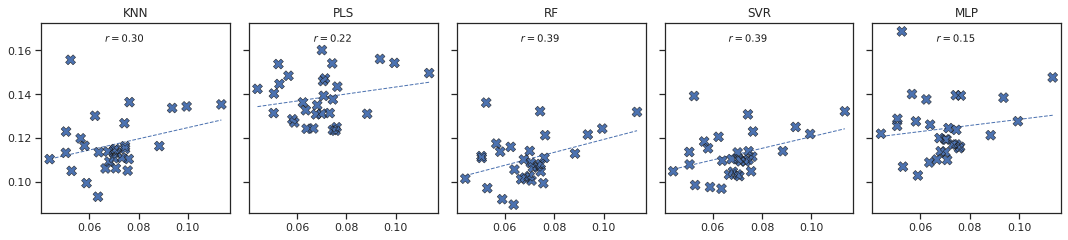

In [17]:
DATASET = 'CHEMBL'
REPR = 'FPS'
METRIC = 'rmse'

nametags = RESULTS[DATASET][REPR].keys()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3.5), sharey=True)

for i, m in enumerate(models.keys()):
    scores = [RESULTS[DATASET][REPR][p]['rogi'] for p in nametags]
    perfs = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[i], scores, perfs, title=m, fit=True)

#axes[0].set_ylabel('CV RMSE')

plt.tight_layout()

In [18]:
# save results to pickle file
with open('regression_results.pkl', 'wb') as f:
    pickle.dump(RESULTS, f)

In [5]:
# load results from pickle file
with open('regression_results.pkl', 'rb') as f:
    RESULTS = pickle.load(f)

In [20]:
# Add results with SARI scores

df_sari = pd.read_csv('regression_sari_scores.csv')
df_sari = df_sari.set_index('dataset')

# augment results
for key in RESULTS['CHEMBL']['FPS'].keys():
    sari_descs = df_sari.loc[key, 'sari_descs']
    sari_morgan = df_sari.loc[key, 'sari_morgan']
    sari_maccs = df_sari.loc[key, 'sari_maccs']
    RESULTS['CHEMBL']['DESC'][key]['sari'] = sari_descs
    RESULTS['CHEMBL']['FPS'][key]['sari'] = sari_morgan
    RESULTS['CHEMBL']['MACCS'][key]['sari'] = sari_maccs

## Plot results

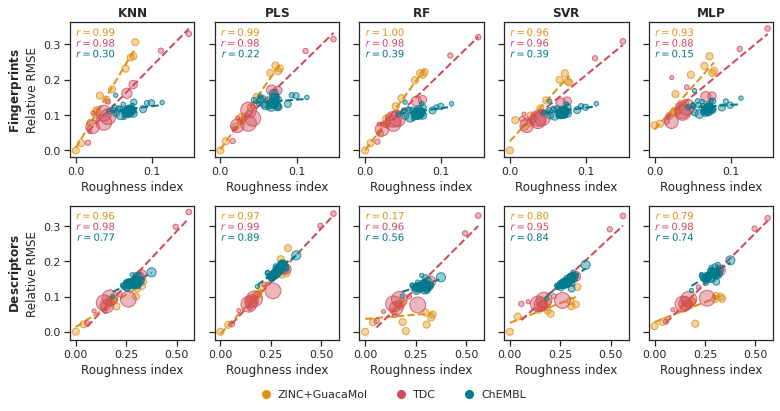

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(11, 5.5), sharey='row', sharex='row')
colors = ['#DF9216','#d1495b','#00798c']

METRIC = 'rmse'
SCORE = 'rogi'

REPR = 'FPS'    
# --------------------
# ZINC + FINGERPRINTS
# --------------------
DATASET = 'ZINC'
nametags = RESULTS[DATASET][REPR].keys()

scores = [RESULTS[DATASET][REPR][p][SCORE] for p in nametags]
for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[0,i], scores, rmses, title=f'$\\bf{m}$', marker='o', s=50, # size 50 = 2000 instances
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[0], edgecolor=colors[0], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[0], x_text=0.37, y_text=0.9, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')

# -------------------
# TDC + FINGERPRINTS
# -------------------
DATASET = 'TDC'
nametags = RESULTS[DATASET][REPR].keys()

scores = [RESULTS[DATASET][REPR][p][SCORE] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[0,i], scores, rmses, title=f'$\\bf{m}$', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=0.37, y_text=0.82, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# -------------------
# TILBORG + FINGERPRINTS
# -------------------
DATASET = 'CHEMBL'
nametags = RESULTS[DATASET][REPR].keys()

scores = [RESULTS[DATASET][REPR][p][SCORE] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[0,i], scores, rmses, title=f'$\\bf{m}$', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[2], edgecolor=colors[2], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[2], x_text=0.37, y_text=0.74, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
REPR = 'DESC'
# --------------------
# ZINC + DESCRIPTORS
# --------------------
DATASET = 'ZINC'
scores = [RESULTS[DATASET][REPR][p][SCORE] for p in oracle_names]
for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in oracle_names]
    plot_scatter(axes[1,i], scores, rmses, title='', marker='o', s=50, 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[0], edgecolor=colors[0], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[0], x_text=0.37, y_text=0.9, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')

# -------------------
# TDC + DESCRIPTORS
# -------------------
DATASET = 'TDC'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][SCORE] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[1,i], scores, rmses, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=0.37, y_text=0.82, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# -------------------
# TILBORG + DESCRIPTORS
# -------------------
DATASET = 'CHEMBL'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][SCORE] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[1,i], scores, rmses, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[2], edgecolor=colors[2], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[2], x_text=0.37, y_text=0.74, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# Fix labels, ticks, etc.
axes[0,0].set_ylabel('$\\bf{Fingerprints}$\nRelative RMSE')
axes[1,0].set_ylabel('$\\bf{Descriptors}$\nRelative RMSE')

for i in range(2):
    for j in range(5):
        axes[i,j].set_xlabel('Roughness index')
        axes[i,j].set_xlabel('Roughness index')

# legend
ms = 8
legend_elements = [Line2D([0], [0], marker='o', linestyle='None', color=colors[0], label='ZINC+GuacaMol', markerfacecolor=colors[0], markersize=ms),
                   Line2D([0], [0], marker='o', linestyle='None', color=colors[1], label='TDC', markerfacecolor=colors[1], markersize=ms),
                   Line2D([0], [0], marker='o', linestyle='None', color=colors[2], label='ChEMBL', markerfacecolor=colors[2], markersize=ms)]

#fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.2), frameon=False)
lgd = fig.legend(handles=legend_elements, loc='lower center', ncol=3, handletextpad=0.1,
                 bbox_to_anchor=(0.5, -0.05), frameon=False, bbox_transform=fig.transFigure)

plt.tight_layout()
fig.savefig('plots/rogi-regression.pdf', bbox_inches='tight')
fig.savefig('plots/rogi-regression.png', dpi=600, bbox_inches='tight')

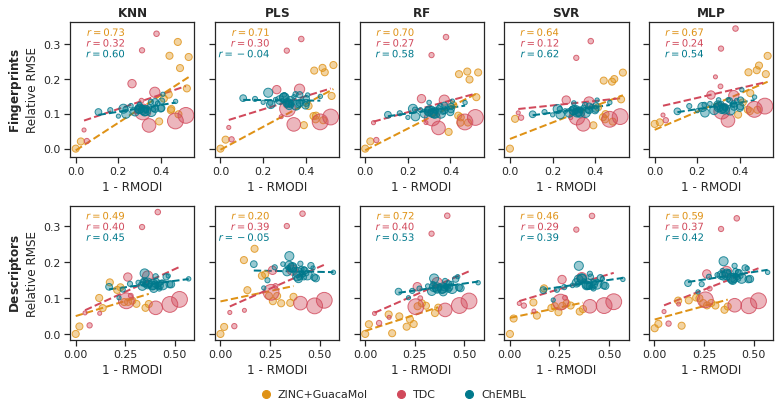

In [23]:
# ==============
# RMODI RESULTS
# ==============

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(11, 5.5), sharey='row', sharex='row')
colors = ['#DF9216','#d1495b','#00798c']

METRIC = 'rmse'
SCORE = 'rmodi'

REPR = 'FPS'
x_text = 0.45

# --------------------
# ZINC + FINGERPRINTS
# --------------------
DATASET = 'ZINC'
nametags = RESULTS[DATASET][REPR].keys()

scores = 1. - np.array([RESULTS[DATASET][REPR][p][SCORE] for p in nametags])
for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[0,i], scores, rmses, title=f'$\\bf{m}$', marker='o', s=50, # size 50 = 2000 instances
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[0], edgecolor=colors[0], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[0], x_text=x_text, y_text=0.9, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')

# -------------------
# TDC + FINGERPRINTS
# -------------------
DATASET = 'TDC'
nametags = RESULTS[DATASET][REPR].keys()

scores = 1. - np.array([RESULTS[DATASET][REPR][p][SCORE] for p in nametags])
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[0,i], scores, rmses, title=f'$\\bf{m}$', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=x_text, y_text=0.82, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# -------------------
# TILBORG + FINGERPRINTS
# -------------------
DATASET = 'CHEMBL'
nametags = RESULTS[DATASET][REPR].keys()

scores = 1. - np.array([RESULTS[DATASET][REPR][p][SCORE] for p in nametags])
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[0,i], scores, rmses, title=f'$\\bf{m}$', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[2], edgecolor=colors[2], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[2], x_text=x_text, y_text=0.74, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
REPR = 'DESC'
# --------------------
# ZINC + DESCRIPTORS
# --------------------
DATASET = 'ZINC'
scores = 1. - np.array([RESULTS[DATASET][REPR][p][SCORE] for p in oracle_names])
for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in oracle_names]
    plot_scatter(axes[1,i], scores, rmses, title='', marker='o', s=50, 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[0], edgecolor=colors[0], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[0], x_text=x_text, y_text=0.9, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')

# -------------------
# TDC + DESCRIPTORS
# -------------------
DATASET = 'TDC'
nametags = RESULTS[DATASET][REPR].keys()
scores = 1. - np.array([RESULTS[DATASET][REPR][p][SCORE] for p in nametags])
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[1,i], scores, rmses, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=x_text, y_text=0.82, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# -------------------
# TILBORG + DESCRIPTORS
# -------------------
DATASET = 'CHEMBL'
nametags = RESULTS[DATASET][REPR].keys()
scores = 1. - np.array([RESULTS[DATASET][REPR][p][SCORE] for p in nametags])
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[1,i], scores, rmses, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[2], edgecolor=colors[2], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[2], x_text=x_text, y_text=0.74, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# Fix labels, ticks, etc.
axes[0,0].set_ylabel('$\\bf{Fingerprints}$\nRelative RMSE')
axes[1,0].set_ylabel('$\\bf{Descriptors}$\nRelative RMSE')

for i in range(2):
    for j in range(5):
        axes[i,j].set_xlabel('1 - RMODI')
        axes[i,j].set_xlabel('1 - RMODI')


# legend
ms = 8
legend_elements = [Line2D([0], [0], marker='o', linestyle='None', color=colors[0], label='ZINC+GuacaMol', markerfacecolor=colors[0], markersize=ms),
                   Line2D([0], [0], marker='o', linestyle='None', color=colors[1], label='TDC', markerfacecolor=colors[1], markersize=ms),
                   Line2D([0], [0], marker='o', linestyle='None', color=colors[2], label='ChEMBL', markerfacecolor=colors[2], markersize=ms)]

#fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.2), frameon=False)
lgd = fig.legend(handles=legend_elements, loc='lower center', ncol=3, handletextpad=0.1,
                 bbox_to_anchor=(0.5, -0.05), frameon=False, bbox_transform=fig.transFigure)

plt.tight_layout()
fig.savefig('plots/rmodi-regression.pdf', bbox_inches='tight')
fig.savefig('plots/rmodi-regression.png', dpi=600, bbox_inches='tight')

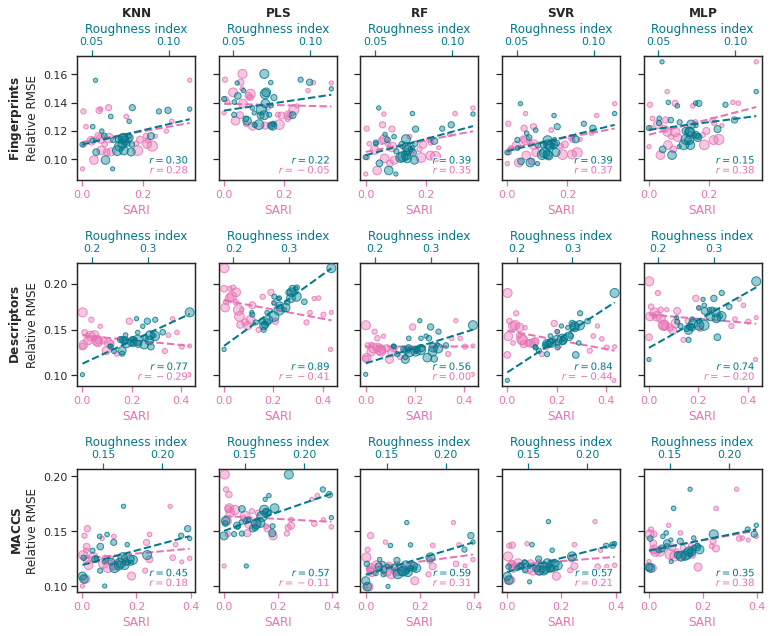

In [25]:
# ======
# SARI
# ======

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(11, 9), sharey='row', sharex=False)
colors = ['#00798c', '#E773B5']  # [ROGI, SARI]

DATASET = 'CHEMBL'
METRIC = 'rmse'

# -------------------
# CHEMBL + FINGERPRINTS
# -------------------
REPR = 'FPS'
nametags = RESULTS[DATASET][REPR].keys()
sari_scores = [RESULTS[DATASET][REPR][p]['sari'] for p in nametags]
rogi_scores = [RESULTS[DATASET][REPR][p]['rogi'] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]

for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[0,i], sari_scores, rmses, title=f'$\\bf{m}$', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=0.95, y_text=0.05, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    # instantiate a second axes that shares the same y-axis
    ax = axes[0,i].twiny()  
    ax.set_xlabel('Roughness index', color=colors[0])
    ax.tick_params(axis='x', colors=colors[0], which='both')
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(ax, rogi_scores, rmses, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[0], edgecolor=colors[0], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[0], x_text=0.95, y_text=0.13, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    

# -------------------
# CHEMBL + DESCRIPTORS
# -------------------
REPR = 'DESC'
nametags = RESULTS[DATASET][REPR].keys()
sari_scores = [RESULTS[DATASET][REPR][p]['sari'] for p in nametags]
rogi_scores = [RESULTS[DATASET][REPR][p]['rogi'] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]

for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[1,i], sari_scores, rmses, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=0.95, y_text=0.05, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    # instantiate a second axes that shares the same y-axis
    ax = axes[1,i].twiny()  
    ax.set_xlabel('Roughness index', color=colors[0])
    ax.tick_params(axis='x', colors=colors[0], which='both')
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(ax, rogi_scores, rmses, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[0], edgecolor=colors[0], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[0], x_text=0.95, y_text=0.13, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# -------------------
# CHEMBL + MACCS
# -------------------
REPR = 'MACCS'    
nametags = RESULTS[DATASET][REPR].keys()
sari_scores = [RESULTS[DATASET][REPR][p]['sari'] for p in nametags]
rogi_scores = [RESULTS[DATASET][REPR][p]['rogi'] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]

for i, m in enumerate(models.keys()):
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(axes[2,i], sari_scores, rmses, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=0.95, y_text=0.05, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    # instantiate a second axes that shares the same y-axis
    ax = axes[2,i].twiny()  
    ax.set_xlabel('Roughness index', color=colors[0])
    ax.tick_params(axis='x', colors=colors[0], which='both')
    rmses = [RESULTS[DATASET][REPR][p][m][METRIC] for p in nametags]
    plot_scatter(ax, rogi_scores, rmses, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[0], edgecolor=colors[0], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[0], x_text=0.95, y_text=0.13, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')

    
# Fix labels, ticks, etc.
axes[0,0].set_ylabel('$\\bf{Fingerprints}$\nRelative RMSE')
axes[1,0].set_ylabel('$\\bf{Descriptors}$\nRelative RMSE')
axes[2,0].set_ylabel('$\\bf{MACCS}$\nRelative RMSE')

for i in range(3):
    for j in range(5):
        axes[i,j].set_xlabel('SARI', color=colors[1])
        axes[i,j].tick_params(axis='x', colors=colors[1], which='both')
        
axes[2,0].set_yticks([0.1,0.15,0.2])

plt.tight_layout()
fig.savefig('plots/sari-regression.pdf', bbox_inches='tight')
fig.savefig('plots/sari-regression.png', dpi=600, bbox_inches='tight')

### Plot distance distributions

In [26]:
distance_matrices_fps = {}

# ZINC
data = MolGen(name='ZINC')
data_sample = data.get_data().sample(n=2000, replace=False, random_state=42)
smiles = data_sample.loc[:, 'smiles'].to_numpy()

oracle = Oracle(name=oracle_names[0])
Y = oracle(list(smiles))
ri = RoughnessIndex(smiles=smiles, Y=Y, verbose=False)
distance_matrices_fps['zinc'] = ri._Dx

Found local copy...
Loading...
Done!


In [27]:
distance_matrices_descs = {}

# -----
# ZINC
# -----
data = MolGen(name='ZINC')
data_sample = data.get_data().sample(n=2000, replace=False, random_state=42)
smiles = data_sample.loc[:, 'smiles'].to_numpy()

oracle = Oracle(name=oracle_names[0])
Y = oracle(list(smiles))

# ----------------
# get descriptors 
# ----------------
descriptor_funcs = {desc[0]:desc[1] for desc in Descriptors.descList}
X = []
for smi in smiles:
    m = Chem.MolFromSmiles(smi)
    Xi = []
    for desc_name in desc_names:
        desc = descriptor_funcs[desc_name](m)
        Xi.append(desc)
    X.append(Xi)

X = np.array(X)
# normalize features (this involves some data leakage and slighly inflates performance, but it does not really matter here)
_X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# ----------------


ri = RoughnessIndex(Y=Y, X=_X, metric='euclidean', verbose=False)
distance_matrices_descs['zinc'] = ri._Dx

Found local copy...
Loading...
Done!


In [28]:
def KDEplot(data=None, x=None, hue=None, hue_order=None, parameter=None, 
            Regions=None, figName=None, meltCol=None,  xlabel=None, 
            ylabel=None, bw_adjust=None, alpha=None):
    colors = [plt.cm.tab20.colors[i:i + 2] for i in 
              range(0, len(data[R].unique()) * 2, 2)]
    hatches = ['', '//////']
    
    for i in parameter:
        f, ax = plt.subplots(figsize=(9.6, 6))
        sns.set_context("paper", rc={"font.size":12, "axes.titlesize":8, 
                                     "axes.labelsize":12})
        handles = []
        for region, palette in zip(Regions, colors):
            ax = sns.kdeplot(data=data[(data[meltCol] == i) & 
                                       (data[R] == region)], x=x, hue=hue, 
                             hue_order=hue_order, multiple='stack', 
                             palette=palette, ax=ax, log_scale=True, 
                             alpha=alpha, bw_adjust=bw_adjust)
            for h, age, hatch in zip(ax.legend_.legendHandles, hue_order, 
                                     hatches):
                h.set_label(f'{region}, {age}')
                h.set_hatch(hatch)
                handles.append(h)
        ax.legend_.remove() # remove the automatic legends
        ax.set(xlabel=xlabel, ylabel=ylabel)
        for collection, hatch in zip(ax.collections[::-1],
                                     hatches * len(Regions)):
            collection.set_hatch(hatch)
        
        ax.legend(handles=handles, loc='best')

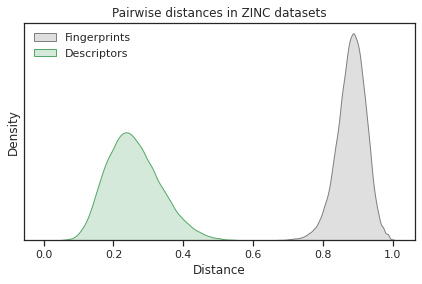

In [30]:
fig, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(np.random.choice(distance_matrices_fps['zinc'], size=100000, replace=False), fill=True, color='grey', ax=ax, linewidth=1, 
            label='Fingerprints')
sns.kdeplot(np.random.choice(distance_matrices_descs['zinc'], size=100000, replace=False), fill=True, color='g', ax=ax, linewidth=1, 
            label='Descriptors')

ax.set_xlabel('Distance')
_ = ax.set_yticks([])
ax.set_title('Pairwise distances in ZINC datasets')

ax.legend(loc=2, frameon=False)
fig.savefig('plots/distance-distributions.png', dpi=600, bbox_inches='tight')

## Plot distribution of RMSEs

In [31]:
data = {}
data['repr'] = []
data['dataset_group'] = []
data['dataset'] = []
data['model'] = []
data['rmse'] = []

for rep in ['FPS', 'DESC']:
    for d in RESULTS.keys():
        for m in models.keys():
            for n in RESULTS[d][rep].keys():
                rmse = RESULTS[d][rep][n][m]['rmse']
                data['dataset_group'].append(d)
                data['dataset'].append(n)
                data['model'].append(m)
                data['rmse'].append(rmse)
                data['repr'].append(rep)
            
df = pd.DataFrame(data)
df

,repr,dataset_group,dataset,model,rmse
0,FPS,ZINC,QED,KNN,0.172596
1,FPS,ZINC,LogP,KNN,0.113819
2,FPS,ZINC,Celecoxib_Rediscovery,KNN,0.109787
3,FPS,ZINC,Aripiprazole_Similarity,KNN,0.098371
4,FPS,ZINC,Median 1,KNN,0.077911
...,...,...,...,...,...
545,DESC,CHEMBL,CHEMBL237_EC50,MLP,0.190136
546,DESC,CHEMBL,CHEMBL2047_EC50,MLP,0.163180
547,DESC,CHEMBL,CHEMBL1862_Ki,MLP,0.164844
548,DESC,CHEMBL,CHEMBL234_Ki,MLP,0.154891


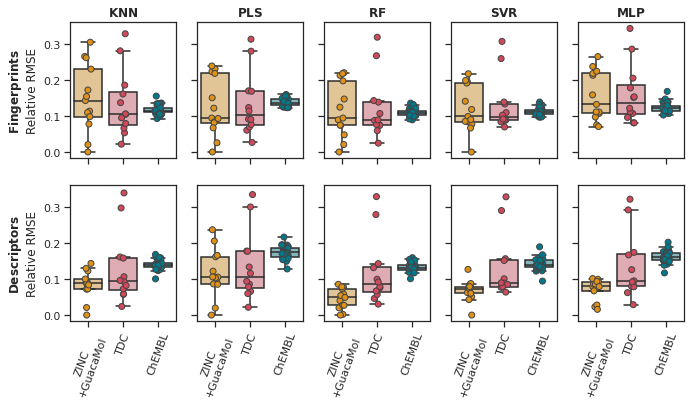

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(11, 5.5), sharey=True, sharex=True)

colors = ['#DF9216','#d1495b','#00798c']

def apply_alpha_to_boxplot(boxplot_obj, alpha=0.5):
    for patch in boxplot_obj.artists:   
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, alpha))

for i, rep in enumerate(['FPS', 'DESC']):
    for j, m in enumerate(models.keys()):
        
        m0 = df.loc[:, 'repr'] == rep
        m1 = df.loc[:, 'model'] == m
        mask = np.logical_and(m0, m1)
        df_sele = df.loc[mask, :]

        box = sns.boxplot(y="rmse", x="dataset_group", data=df_sele, ax=axes[i,j], palette=colors, showfliers=False)
        strip = sns.stripplot(y="rmse", x="dataset_group", data=df_sele, ax=axes[i,j], dodge=True, alpha=1, zorder=10, 
                              size=6, edgecolor='#444444', linewidth=1, palette=colors)
        apply_alpha_to_boxplot(box, 0.5)
        
        # labels
        axes[i,j].set_xlabel('')
        axes[i,j].set_ylabel('')
        if i == 0:
            axes[i,j].set_title(f'$\\bf{m}$')
        
axes[0,0].set_ylabel('$\\bf{Fingerprints}$\nRelative RMSE')
axes[1,0].set_ylabel('$\\bf{Descriptors}$\nRelative RMSE')
for j in range(5):
    axes[1,j].set_xticklabels(['ZINC\n+GuacaMol', 'TDC', 'ChEMBL'], rotation=70)

fig.savefig('plots/regression-rmse_boxplots.png', dpi=600, bbox_inches='tight')
fig.savefig('plots/regression-rmse_boxplots.pdf', bbox_inches='tight')